In [1]:
import numpy as np
import os
from ddlraw import Raw
from ddldetect import Detect
from ddlsorted import Sorted
from ddlneurons import Neurons

In [2]:
recording_name = '20160415_patch2'
Dir = os.path.join('C:/Users/liuxj/Desktop/生医专业/专业实践综合训练2/raw_data',recording_name)
file_name = 'patch_2_MEA.raw'
offset=1871
data = np.memmap(os.path.join(Dir,file_name),dtype='uint16',offset=offset,mode='r')
data = data.reshape(len(data)//256,256)
data = data[:,7:9]#选取示例电极，其中7号电极可以较好地看到两个神经元的信号
data = data.astype('float32')

time_series = data
Fs = 20000
print(time_series)
print(Fs)

[[32798. 32778.]
 [32793. 32813.]
 [32745. 32788.]
 ...
 [33104. 32754.]
 [32919. 32755.]
 [32772. 32773.]]
20000


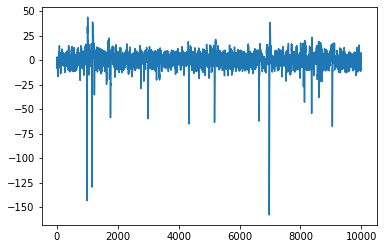

In [3]:
import matplotlib.pyplot as plt
#观察原始波形
raw = Raw(time_series,Fs)
raw.scale(1,-2**15-1)
raw.scale(0.1042,0)
raw.set_unit('uV')
plt.plot(raw.data[0:10000,0])
plt.show()

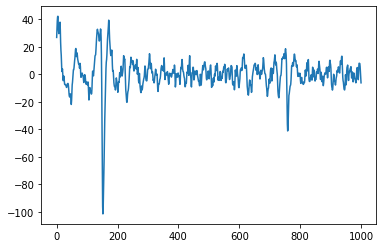

In [4]:
#滤波
spikes = raw.get_spikes()
plt.plot(spikes.data[1000:2001,0])
plt.show()

In [5]:
#峰值检测
detect = spikes.extract_by_median(5)
print(detect.n_spikes)


[7033 2926]


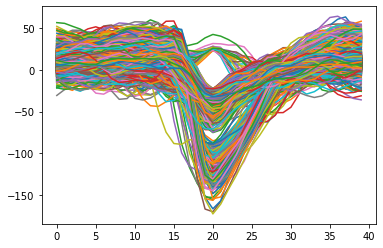

In [6]:
#观察波形分布
waveforms = detect.waveforms[0]
for i in range(np.shape(waveforms)[0]):
    plt.plot(waveforms[i,:])

In [6]:
#去除疑似非锋电位的正向波形
nega = detect.mannual_select_by_peaks(list(range(detect.n_channels)),[float('-inf') for i in range(detect.n_channels)],np.zeros([detect.n_channels]))
print(nega.n_spikes)

[7009 2886]


In [7]:
#使用“自然断点”法分类
sorted_result = nega.sort_by_natural_break()

Divide into 3 classes
[-172.17512631560407, -84.88179346360639, -37.213628409159526, -22.684113020206944]
Divide into 3 classes
[-90.82497141445856, -35.03416395215371, -25.354315756201707, -16.58132626480143]


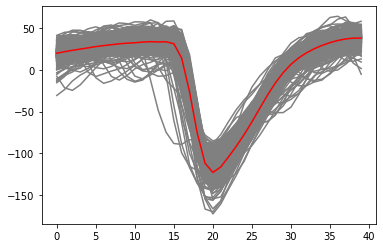

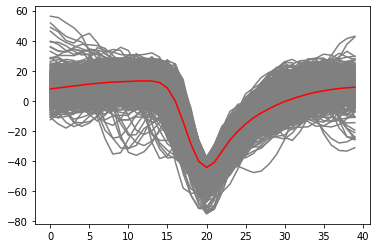

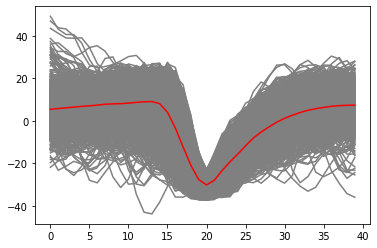

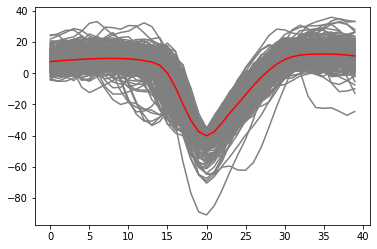

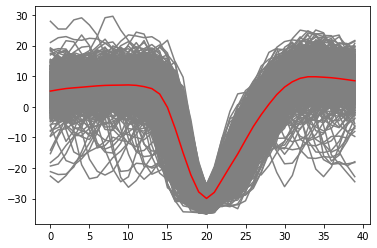

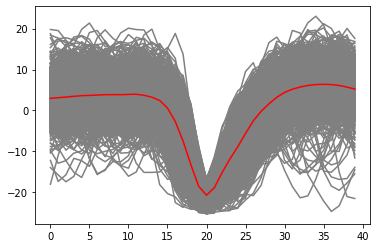

In [8]:
#绘制分出的每个神经元的平均波形
sorted_result.plot_neuron(0)
sorted_result.plot_neuron(1)

[ 2.61        7.41       13.34333333]
[1.75       3.23666667 4.63333333]


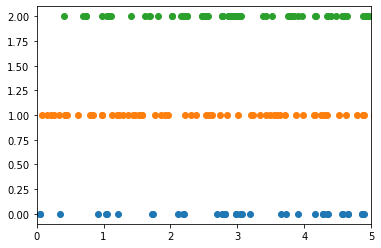

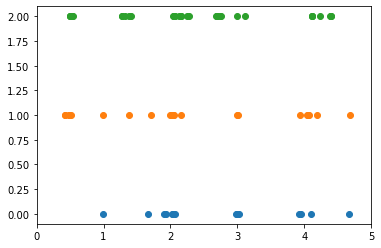

In [9]:
#绘制每个神经元的发放时刻，如下图所示，第1、2个神经元发放时刻高度相关，似应为同一个，在连续发放时幅值变小，被自动分类为两个
for ch in range(sorted_result.n_channels):
    print(sorted_result.firing_rate[ch])
    plt.figure()
    for i in range(sorted_result.n_neurons[ch]):
        plt.scatter(sorted_result.time_points[ch][i],[i for ii in range(len(sorted_result.time_points[ch][i]))])
        plt.xlim([0,5])

In [8]:
#两种分类后结果数据类型相互转换
neurons = sorted_result.to_Neurons()
back = neurons.to_Sorted()
print(sorted_result.result==back.result)
print(sorted_result.time_points==back.time_points)
print(sorted_result.neuron_id==back.neuron_id)

True
True
True


isi_threshold= 0.08240000000000691
lamda= 0.08883642713764811


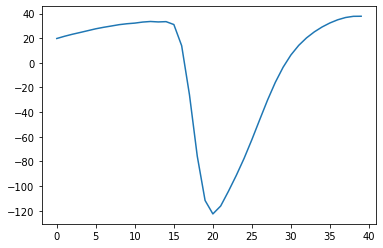

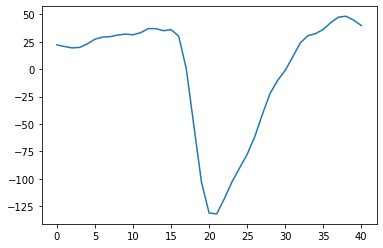

isi_threshold= 0.08254999999999768
lamda= 0.024785959732758357


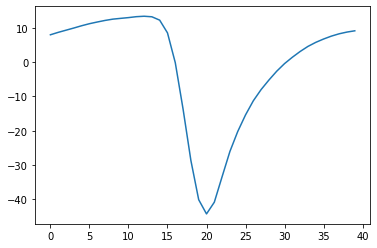

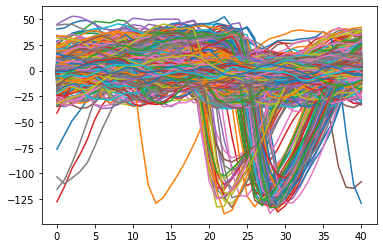

isi_threshold= 0.09040000000001669
lamda= -0.0001031587340192603
isi_threshold= 0.059449999999998226
lamda= -0.029267843983582634
isi_threshold= 0.052149999999983265
lamda= 0.004295020254444338


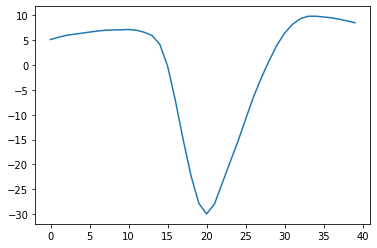

isi_threshold= 0.06295000000000073
lamda= 0.01137547308504063


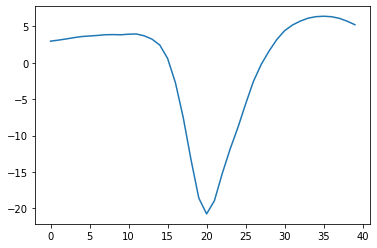

In [17]:
#试了一下基于模板匹配的burst检测，效果比较奇怪，会匹配到很多一看就不对劲的东西
neo_neurons = neurons.find_bursts(spikes,200)

In [18]:
for i in range(neurons.n_neurons):
    print(np.shape(neo_neurons.time_points[i]))
    print(np.shape(neurons.time_points[i]))

(784,)
(783,)
(7614,)
(2223,)
(4003,)
(4003,)
(525,)
(525,)
(971,)
(971,)
(1390,)
(1390,)
